In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sys
import torch
import pickle
import lmdb
import psutil

In [2]:
data_path = './e-ViL/data/'
train = pd.read_csv(data_path+'esnlive_train.csv')
test = pd.read_csv(data_path+'esnlive_test.csv')
dev = pd.read_csv(data_path+'esnlive_dev.csv')
results = pd.read_csv(data_path+'flickr30k_images/results.csv', sep ='|')

In [3]:
print("Train len: ",len(train.index))
print("Test len: ",len(test.index))
print("Devlen: ",len(dev.index))

Train len:  401717
Test len:  14740
Devlen:  14339


In [4]:
frames = [train,test,dev]
full = pd.concat(frames)
train.head()

,Unnamed: 0,pairID,Flickr30kID,hypothesis,gold_label,explanation
0,0,4564320256.jpg#1r1c,4564320256.jpg,Two old men robbing a convenience store.,contradiction,A lady and her granddaughter cannot also be tw...
1,1,4564320256.jpg#1r1e,4564320256.jpg,Two humans in a store.,entailment,A lady and a granddaughter are both types of h...
2,2,4564320256.jpg#1r1n,4564320256.jpg,A mother teaching her granddaughter how to run...,neutral,Just because the old lady and her granddaughte...
3,3,4564320256.jpg#0r1c,4564320256.jpg,The lady and the girl are taking a walk to the...,contradiction,The lady and girl are surrounded by newspapers...
4,4,4564320256.jpg#2r1c,4564320256.jpg,The old lady is a zombie.,contradiction,"If the old woman is a zombie, she would be try..."


In [5]:
len(full.index)

430796

In [6]:
full.nunique()

Unnamed: 0     401717
pairID         430796
Flickr30kID     31783
hypothesis     374937
gold_label          3
explanation    414216
dtype: int64

In [7]:
duplicate_images=full[full.duplicated(subset=['Flickr30kID'])]
print(len(duplicate_images))
print(len(full.index)-len(duplicate_images))
full[full['Flickr30kID']=='4564320256.jpg']

399013
31783


,Unnamed: 0,pairID,Flickr30kID,hypothesis,gold_label,explanation
0,0,4564320256.jpg#1r1c,4564320256.jpg,Two old men robbing a convenience store.,contradiction,A lady and her granddaughter cannot also be tw...
1,1,4564320256.jpg#1r1e,4564320256.jpg,Two humans in a store.,entailment,A lady and a granddaughter are both types of h...
2,2,4564320256.jpg#1r1n,4564320256.jpg,A mother teaching her granddaughter how to run...,neutral,Just because the old lady and her granddaughte...
3,3,4564320256.jpg#0r1c,4564320256.jpg,The lady and the girl are taking a walk to the...,contradiction,The lady and girl are surrounded by newspapers...
4,4,4564320256.jpg#2r1c,4564320256.jpg,The old lady is a zombie.,contradiction,"If the old woman is a zombie, she would be try..."
5,5,4564320256.jpg#2r1n,4564320256.jpg,The mother and daughter are bored.,neutral,Just because the woman and young girl are sitt...
6,6,4564320256.jpg#4r1e,4564320256.jpg,Two women reading the paper together.,entailment,The women reading newspapers which implies tha...


In [8]:
duplicate_ID=full[full.duplicated(subset=['pairID'])]
duplicate_ID

,Unnamed: 0,pairID,Flickr30kID,hypothesis,gold_label,explanation


In [9]:
full

,Unnamed: 0,pairID,Flickr30kID,hypothesis,gold_label,explanation
0,0,4564320256.jpg#1r1c,4564320256.jpg,Two old men robbing a convenience store.,contradiction,A lady and her granddaughter cannot also be tw...
1,1,4564320256.jpg#1r1e,4564320256.jpg,Two humans in a store.,entailment,A lady and a granddaughter are both types of h...
2,2,4564320256.jpg#1r1n,4564320256.jpg,A mother teaching her granddaughter how to run...,neutral,Just because the old lady and her granddaughte...
3,3,4564320256.jpg#0r1c,4564320256.jpg,The lady and the girl are taking a walk to the...,contradiction,The lady and girl are surrounded by newspapers...
4,4,4564320256.jpg#2r1c,4564320256.jpg,The old lady is a zombie.,contradiction,"If the old woman is a zombie, she would be try..."
...,...,...,...,...,...,...
14334,14334,3313237692.jpg#0r1e,3313237692.jpg,Two girls are standing next to a girl who is s...,entailment,There are two girls next to a girl sitting so ...
14335,14335,3313237692.jpg#0r1c,3313237692.jpg,The three girls are arm wrestling in China town.,contradiction,One cannot say they stand if they are arm wres...
14336,14336,2581058635.jpg#3r1c,2581058635.jpg,A man is swimming in the ocean.,contradiction,One cannot be squatting and swimming simultane...
14337,14337,2871984109.jpg#1r1c,2871984109.jpg,The San Francisco 49ers cheerleaders perform i...,contradiction,Performing on a football field is contradictor...


In [10]:
print(list(full.columns))

['Unnamed: 0', 'pairID', 'Flickr30kID', 'hypothesis', 'gold_label', 'explanation']


In [11]:
print(list(train.columns))

['Unnamed: 0', 'pairID', 'Flickr30kID', 'hypothesis', 'gold_label', 'explanation']


In [12]:
print(list(test.columns))

['Unnamed: 0', 'pairID', 'Flickr30kID', 'hypothesis', 'gold_label', 'explanation']


In [13]:
print(list(dev.columns))

['Unnamed: 0', 'pairID', 'Flickr30kID', 'hypothesis', 'gold_label', 'explanation']


In [14]:
hyp_len = full['hypothesis'].apply(len).tolist()
hyp_len.sort()
len(hyp_len)
hyp_len[-100:]

[153,
 153,
 153,
 153,
 153,
 153,
 153,
 154,
 154,
 154,
 154,
 154,
 155,
 155,
 155,
 155,
 156,
 157,
 157,
 157,
 157,
 157,
 158,
 158,
 158,
 158,
 158,
 159,
 159,
 159,
 159,
 160,
 160,
 161,
 162,
 162,
 162,
 163,
 163,
 163,
 163,
 164,
 165,
 165,
 165,
 165,
 166,
 166,
 166,
 166,
 167,
 167,
 167,
 168,
 168,
 168,
 170,
 170,
 171,
 171,
 171,
 173,
 173,
 173,
 173,
 174,
 174,
 174,
 175,
 176,
 176,
 177,
 177,
 177,
 178,
 179,
 180,
 183,
 185,
 187,
 188,
 188,
 188,
 190,
 190,
 190,
 190,
 191,
 191,
 192,
 193,
 202,
 203,
 204,
 206,
 232,
 241,
 246,
 275,
 295]

In [15]:
hyp_len_np = np.array(hyp_len)
p = np.percentile(hyp_len_np, 90)
p

58.0

In [34]:
hyp_len_np = np.array(hyp_len)
p = np.percentile(hyp_len_np, 90)
p

58.0

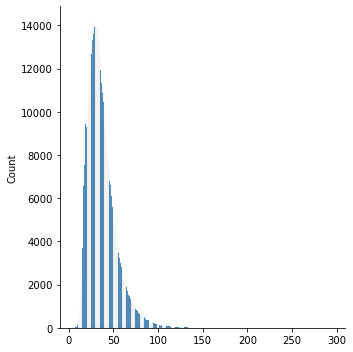

In [17]:
sns.displot(hyp_len)

In [18]:
all_images = set(full['Flickr30kID'])
len(all_images)

31783

In [19]:
sys.getsizeof([torch.tensor([1,2,3]),2,3])

80

In [20]:
a = 10
b=a
a = 9
b

10

In [21]:
class MyImages():
    def __init__(self,image_path,img_names,device):
        self.device = device
        self.img_dict = {}
        img_env = lmdb.open(
            image_path, readonly=True, create=False, readahead=not False
        )
        img_txn = img_env.begin(buffers=True)
        for img_name in img_names:
            item_img = pickle.loads(img_txn.get(img_name.encode()))
            img_list = []
            img_list.append(torch.tensor(item_img['normalized_boxes'][0], dtype = torch.float32, device = self.device))
            img_list.append(torch.tensor(item_img['features'][0], dtype = torch.float32, device = self.device))
            self.img_dict[img_name] = img_list
        img_env.close()
        return
    
    def get_img(self,img_name):
        return self.img_dict.get(img_name)

In [22]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [23]:
c = MyImages('./lxmert/my_image_db',all_images,device)

In [28]:
total_size = 0
for key in c.img_dict:
    total_size+=sys.getsizeof(c.img_dict[key][0].storage())
    total_size+=sys.getsizeof(c.img_dict[key][1].storage())
total_size/1024/1024/1024

8.749353021383286

In [31]:
psutil.cpu_percent()

4.6

In [32]:
# gives an object with many fields
psutil.virtual_memory()

svmem(total=8381452288, available=2465271808, percent=70.6, used=5916180480, free=2465271808)

In [33]:
# you can convert that object to a dictionary 
dict(psutil.virtual_memory()._asdict())

{'total': 8381452288,
 'available': 2473500672,
 'percent': 70.5,
 'used': 5907951616,
 'free': 2473500672}

In [34]:
# you can have the percentage of used RAM
psutil.virtual_memory().percent

70.3

In [35]:
# you can calculate percentage of available memory
psutil.virtual_memory().available * 100 / psutil.virtual_memory().total

29.777842720328326